In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
# Importamos nuestras propias funciones
sys.path.append('drive/MyDrive/TFG/src/')

In [ ]:
# from google.colab import files
# files.view('drive/MyDrive/TFG/data_visualization.py')

In [ ]:
from numpy import array
import keras
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from data_preparation import train_test_split, scale
from supervised_learning import to_supervised, prior_inverse, invert_scale
from evaluation import measure_rmse, summarize_scores
from data_visualization import boxplot_errors, plot_loss, plot_metrics, plot_pred_vs_real, residuals_dist, residuals_vs_pred


# fit a model
def model_fit(train_x, train_y, test_x, test_y, config):
  # unpack config
  n_input, n_nodes, n_epochs, n_batch, dropout = config

  # Prepare data
  n_features = train_x.shape[2]
  train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))

  early_stopping = EarlyStopping(patience=5, monitor='loss')
  # define model
  model = keras.Sequential()
  model.add(LSTM(n_nodes, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
  model.add(Dropout(dropout))
  model.add(LSTM(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1))

  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  # fit
  history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[early_stopping], validation_data = (test_x, test_y))
  return model, history

# forecast with a pre-fit model
def model_predict(model, history, config):
  # unpack config
  n_input, _, _, _, _ = config
  # prepare data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  x_input = data[-n_input:]
  x_input = x_input.reshape((1, n_input, x_input.shape[1]))
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]


# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  # split dataset
  train, test = train_test_split(data, n_test)
  # prepare data
  train = train.to_numpy()
  test = test.to_numpy()

  # Escalamos entre 0 y 1
  scaler, train_scaled, test_scaled = scale(train, test, 0, 1)

  n_input, _, _, _, _ = cfg
  # Dividimos en arrays las valores de entrenamiento y test
  train_x, train_y = to_supervised(train_scaled, n_input)
  test_x, test_y = to_supervised(test_scaled, n_input)
  # fit model
  model, history = model_fit(train_x, train_y, test_x, test_y, cfg)
  # seed history with training dataset
  history_train = [x for x in train_x]
  # step over each time-step in the test set
  predictions = list()
  for i in range(len(test_x)):
    # fit model and make forecast for history
    yhat = model_predict(model, history_train, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history_train.append(test_x[i])

  # Obtenemos los valores en la escala inicial
  power_pred, power_real = invert_scale(scaler, test_x, test_y, predictions)

  # estimate prediction error
  rmse = measure_rmse(power_real, power_pred)
  mae =  mean_absolute_error(power_real, power_pred)
  r2 = r2_score(power_real, power_pred)

  return rmse, mae, r2, history, power_pred, power_real

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
  # convert config to a key
  key = str(config)
  # fit and evaluate the model n times
  inicio = time.time()
  scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
  fin = time.time()
  # Calcular la duración en segundos
  duracion_segundos = fin - inicio

  # Convertir la duración a minutos y segundos
  duracion_minutos, duracion_segundos = divmod(duracion_segundos, 60)
  print(key, "Tiempo transcurrido:", int(duracion_minutos), "minutos y", int(duracion_segundos), "segundos")
  return (key, scores)

# grid search configs
def grid_search(data, cfg_list, n_test):
  # evaluate configs
  scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
  return scores

### Energía fotovoltaica

In [ ]:
import pandas as pd
import time
# Datos totales de energía fotovoltaica
df = pd.read_csv('drive/MyDrive/TFG/data/PV_data.csv', index_col='Time')

# Datos primer año
divide = '2020-01-01'
first_year = df.loc[:divide]

# Configuraciones a testear
# n_steps, n_nodes, n_epochs, n_batch, dropout
configs =  [[24, 50, 15, 150, 0.3], [24, 30, 30, 150, 0.2]]

# Fechas inicial del test
start_test = '2019-09-31'
scores_1 = grid_search(first_year, configs, start_test)

[24, 50, 15, 150, 0.3] Tiempo transcurrido: 3 minutos y 58 segundos
[24, 30, 30, 150, 0.2] Tiempo transcurrido: 4 minutos y 53 segundos


In [ ]:
# Datos segundo año
# divide = '2020-01-01'
second_year = df.loc[divide:]

# Configuraciones a testear
# n_steps, n_nodes, n_epochs, n_batch, dropout
# configs =  [[24, 50, 15, 150, 0.3], [24, 30, 30, 150, 0.2]]


# Fecha inicial del test
start_test = '2020-09-31'
scores_2 = grid_search(second_year, configs, start_test)

[24, 50, 15, 150, 0.3] Tiempo transcurrido: 3 minutos y 54 segundos
[24, 30, 30, 150, 0.2] Tiempo transcurrido: 3 minutos y 48 segundos


Config [24, 50, 15, 150, 0.3]
                 RMSE       MAE        R2
Iteración 1  6.937028  3.835461  0.736238
Iteración 2  8.675328  4.928132  0.583254
Stacked LSTM: 7.806 RMSE (+/- 0.869)
Stacked LSTM: 4.382 MAE (+/- 0.546)
Stacked LSTM: 0.660 R2 (+/- 0.076)


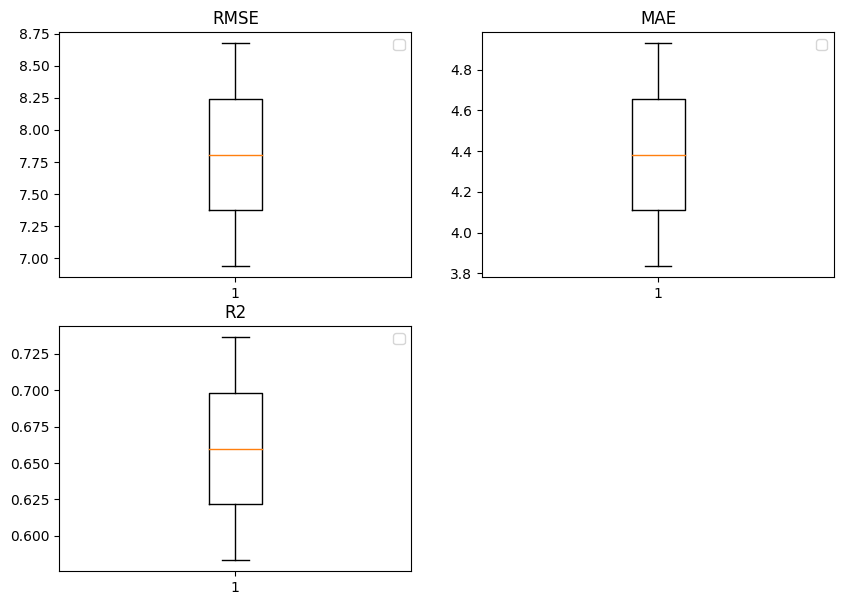

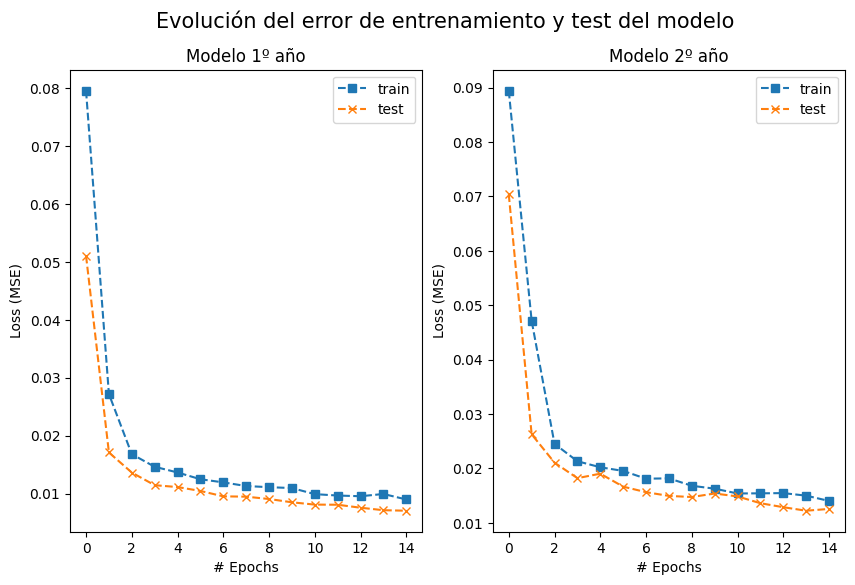

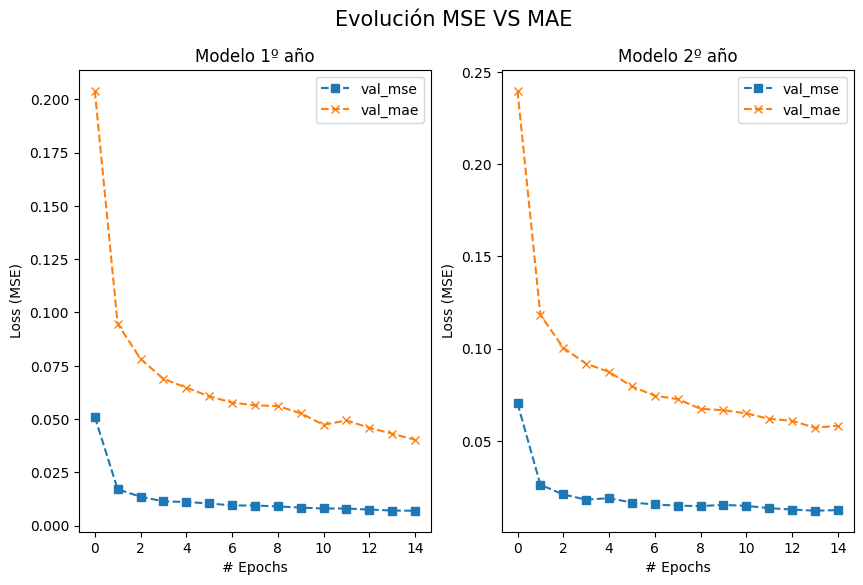

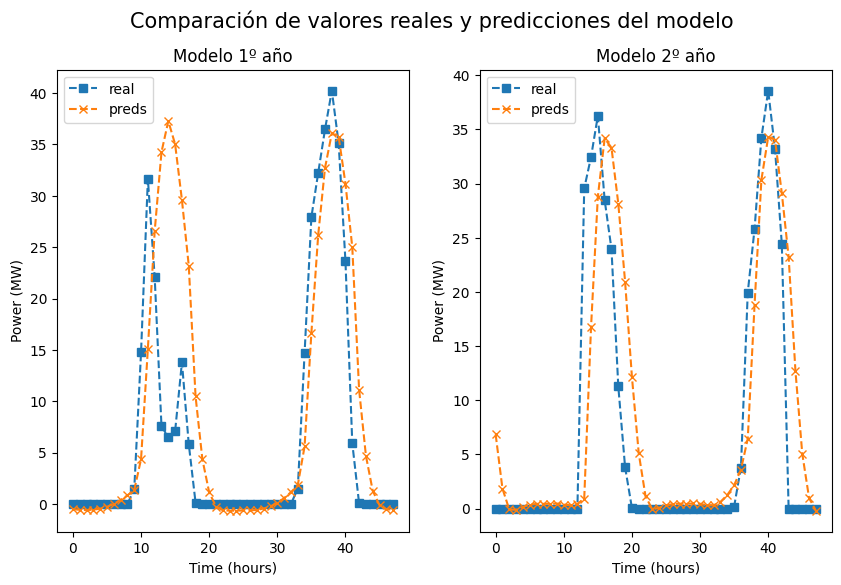

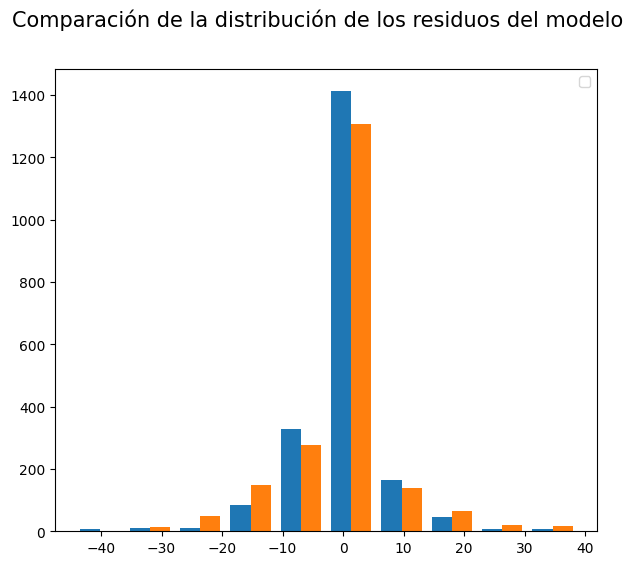

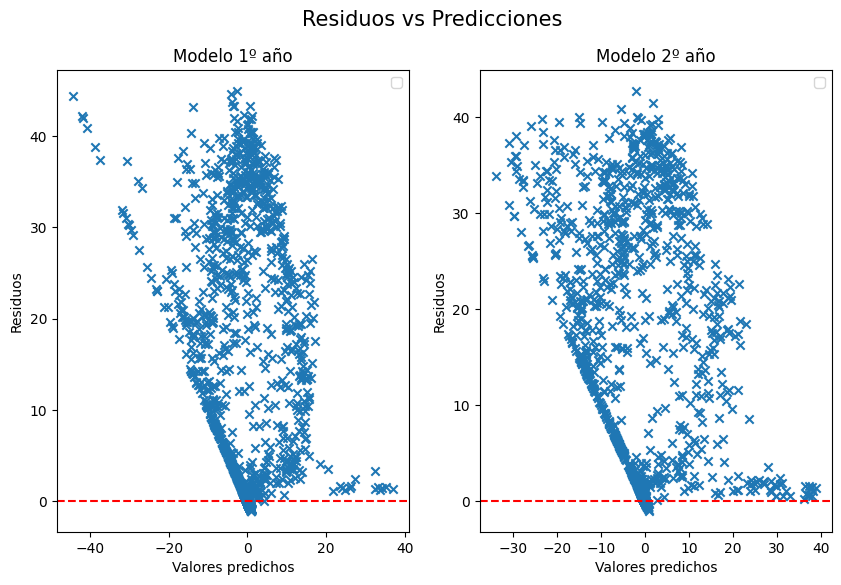

Config [24, 30, 30, 150, 0.2]
                 RMSE       MAE        R2
Iteración 1  6.971343  3.954858  0.733622
Iteración 2  8.570480  4.865565  0.593266
Stacked LSTM: 7.771 RMSE (+/- 0.800)
Stacked LSTM: 4.410 MAE (+/- 0.455)
Stacked LSTM: 0.663 R2 (+/- 0.070)


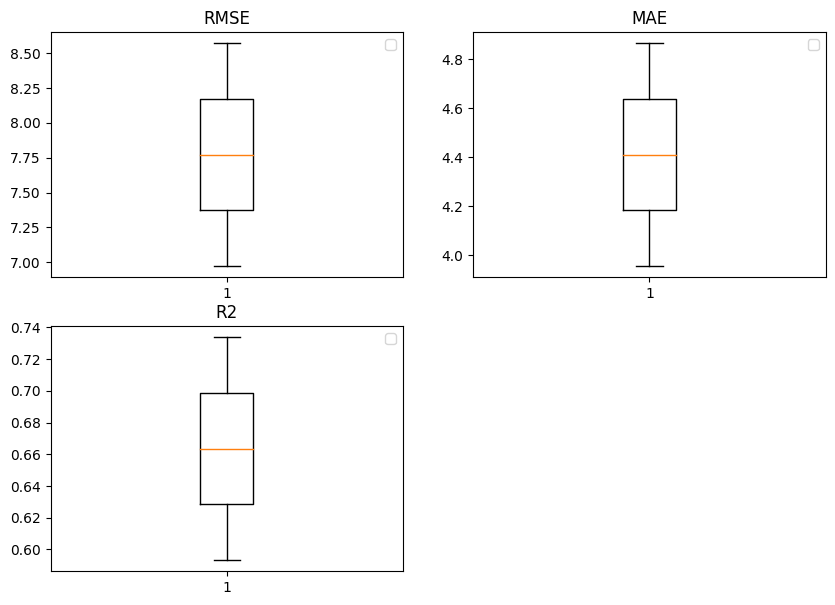

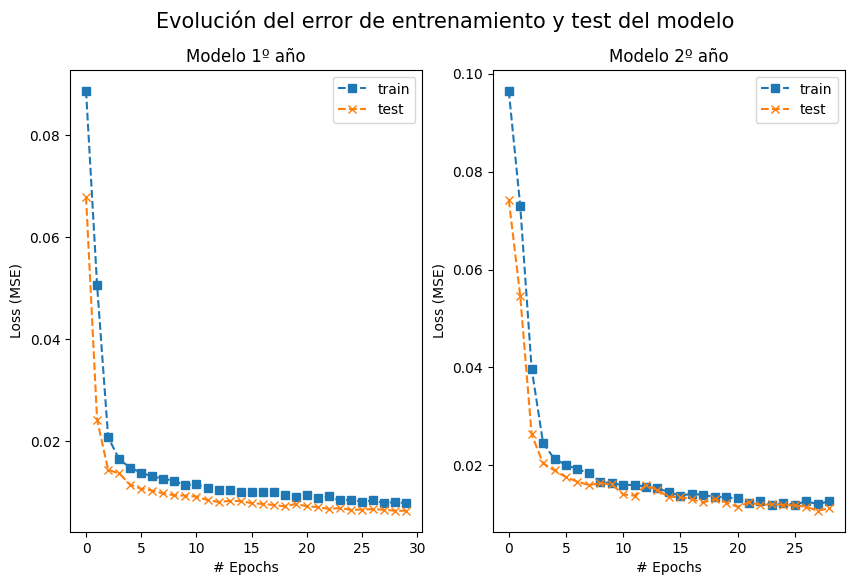

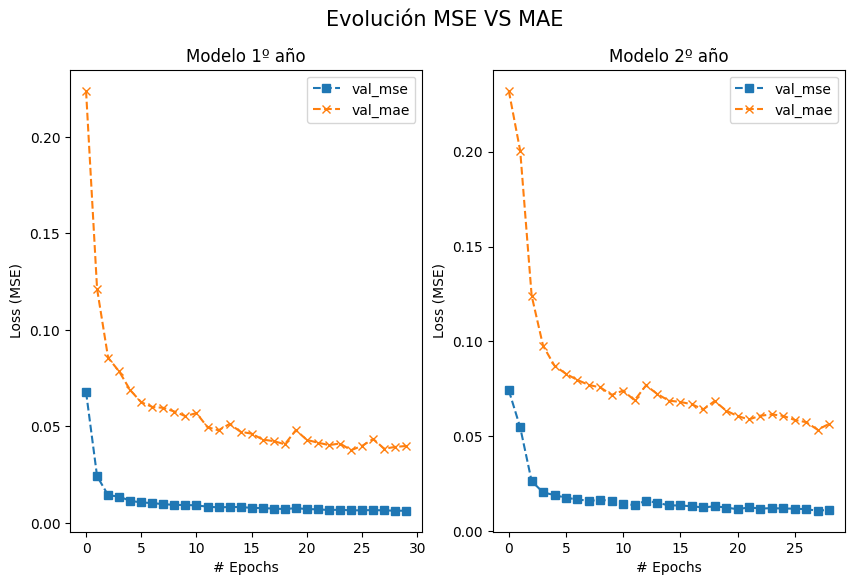

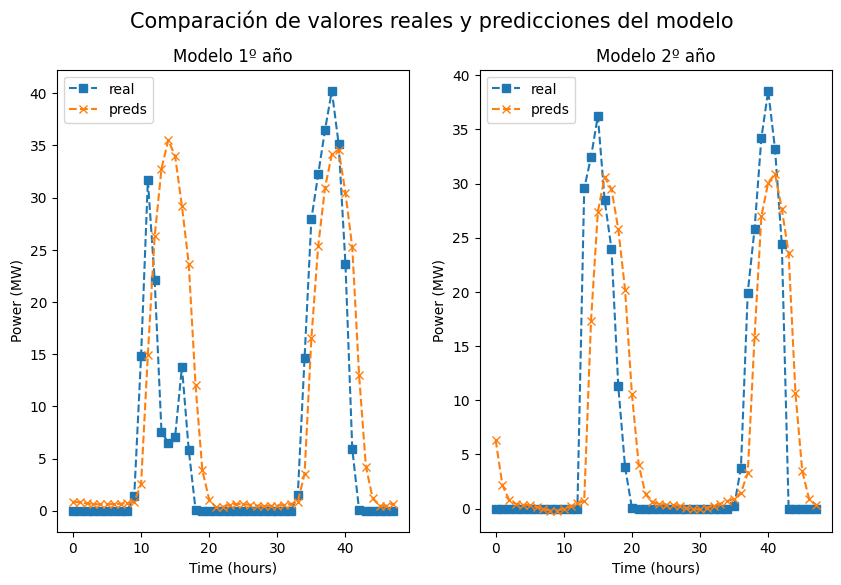

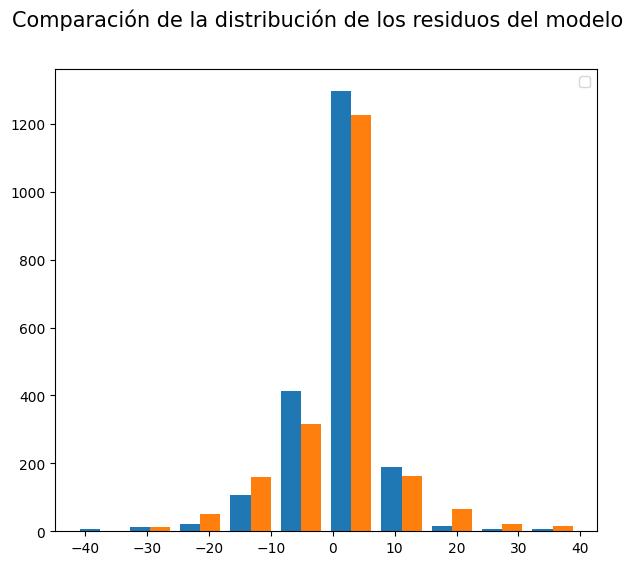

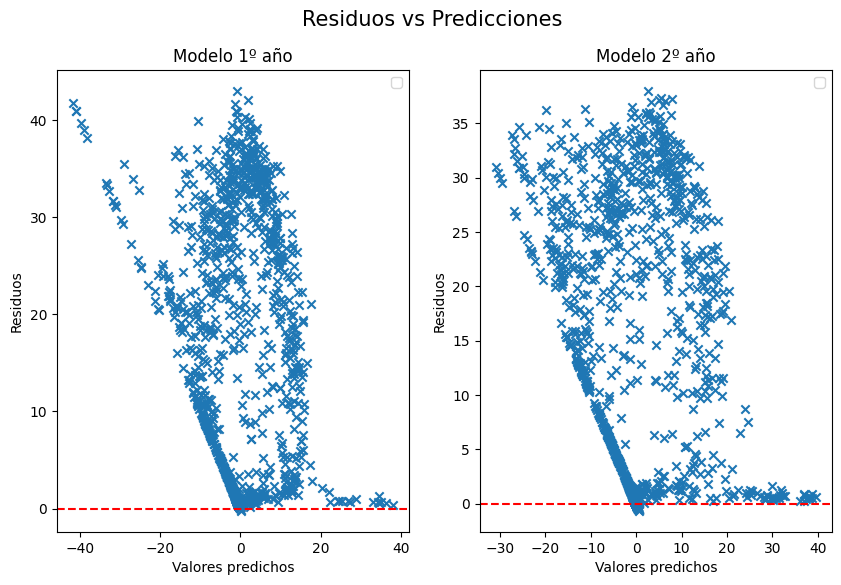

In [ ]:
scores = {config_1: (results_1, results_2) for (config_1, results_1), (config_2, results_2) in zip(scores_1, scores_2) if config_1 == config_2}
summarize_scores('Stacked LSTM', scores)

### Energía eólica

In [ ]:
# Datos totales de la energía eólica
df = pd.read_csv('drive/MyDrive/TFG/data/EO_data.csv', index_col='Time')

# Datos primer año
# divide = '2020-01-01'
first_year = df.loc[:divide]

# Configuraciones a testear
# n_steps, n_nodes, n_epochs, n_batch, dropout
configs =  [[24*7, 50, 15, 150, 0.3], [24*7, 30, 30, 150, 0.2]]

# Fecha inicial del test
start_test = '2019-09-31'
scores_1 = grid_search(first_year, configs, start_test)

[168, 50, 15, 150, 0.3] Tiempo transcurrido: 9 minutos y 41 segundos
[168, 30, 30, 150, 0.2] Tiempo transcurrido: 14 minutos y 34 segundos


In [ ]:
# df = pd.read_csv('drive/MyDrive/TFG/data/EO_data.csv', index_col='Time')

# Datos segundo año
# divide = '2020-01-01'
second_year = df.loc[divide:]

# Configuraciones a testear
# n_steps, n_nodes, n_epochs, n_batch, dropout
# configs =  [[24*7, 50, 15, 150, 0.3], [24*7, 30, 30, 150, 0.2]]

# Fecha inicial del test
start_test = '2020-09-31'
scores_2 = grid_search(second_year, configs, start_test)

[168, 50, 15, 150, 0.3] Tiempo transcurrido: 8 minutos y 43 segundos
[168, 30, 30, 150, 0.2] Tiempo transcurrido: 13 minutos y 29 segundos


Config [168, 50, 15, 150, 0.3]
                  RMSE       MAE        R2
Iteración 1  13.795326  9.414169  0.712473
Iteración 2  14.275289  8.951135  0.667940
Stacked LSTM: 14.035 RMSE (+/- 0.240)
Stacked LSTM: 9.183 MAE (+/- 0.232)
Stacked LSTM: 0.690 R2 (+/- 0.022)


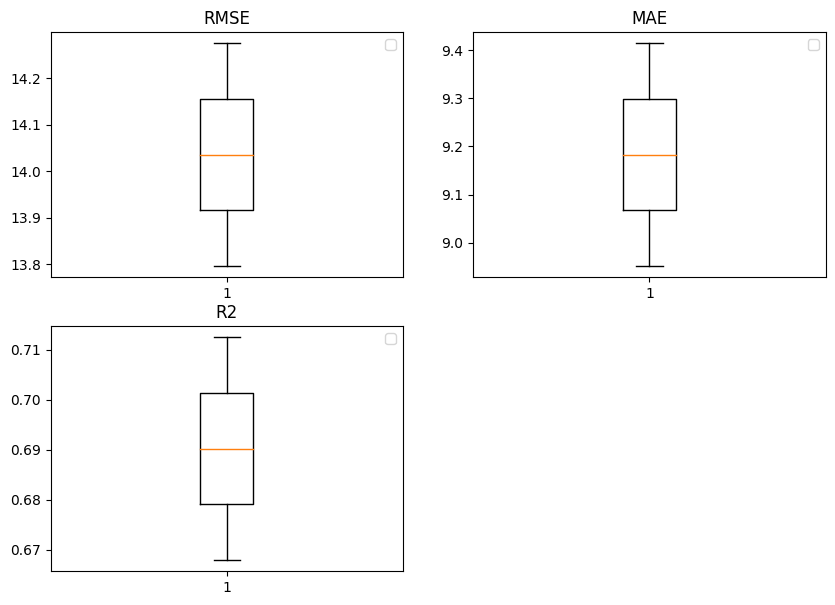

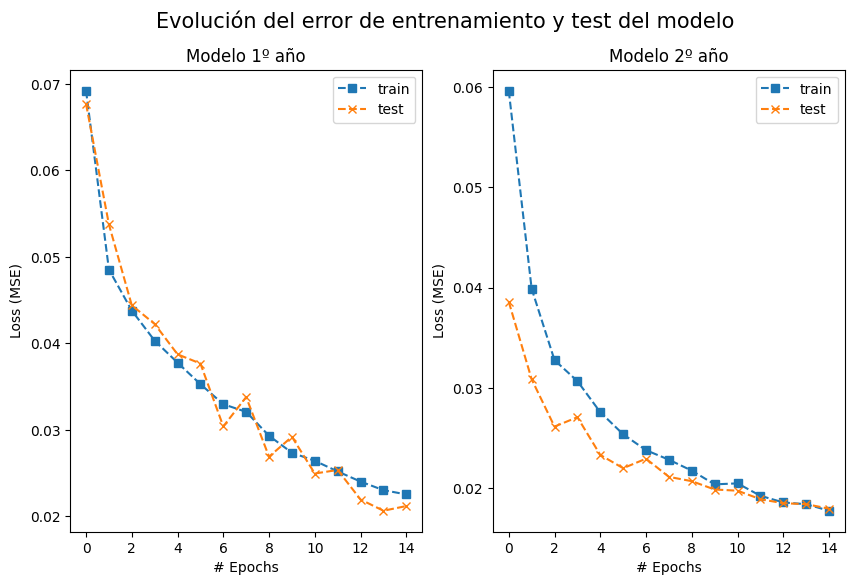

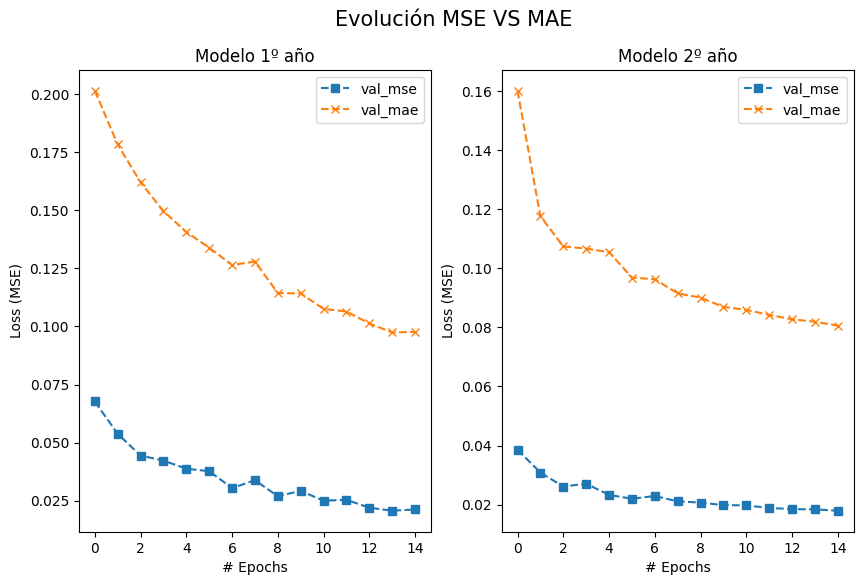

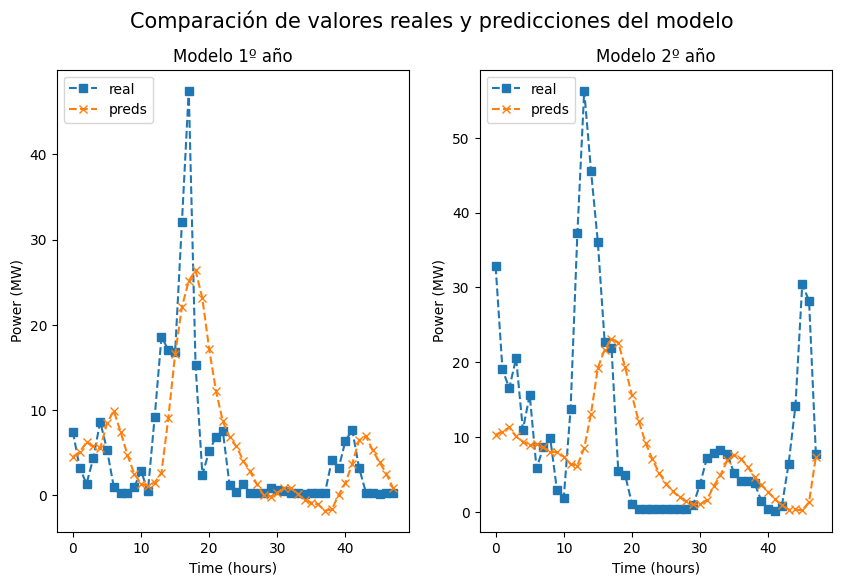

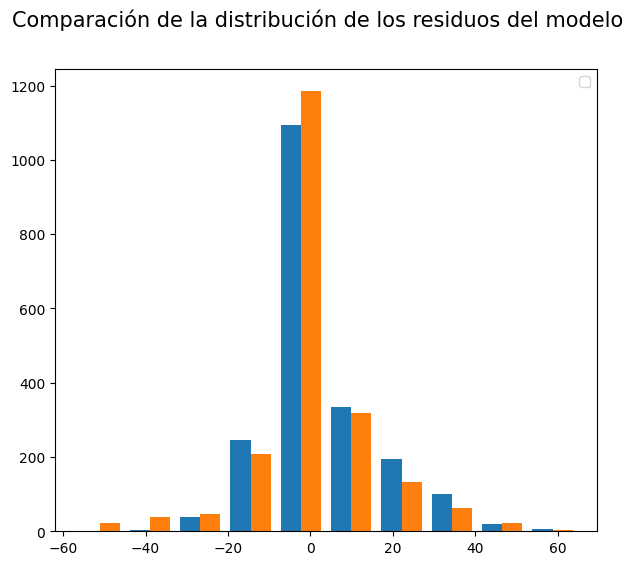

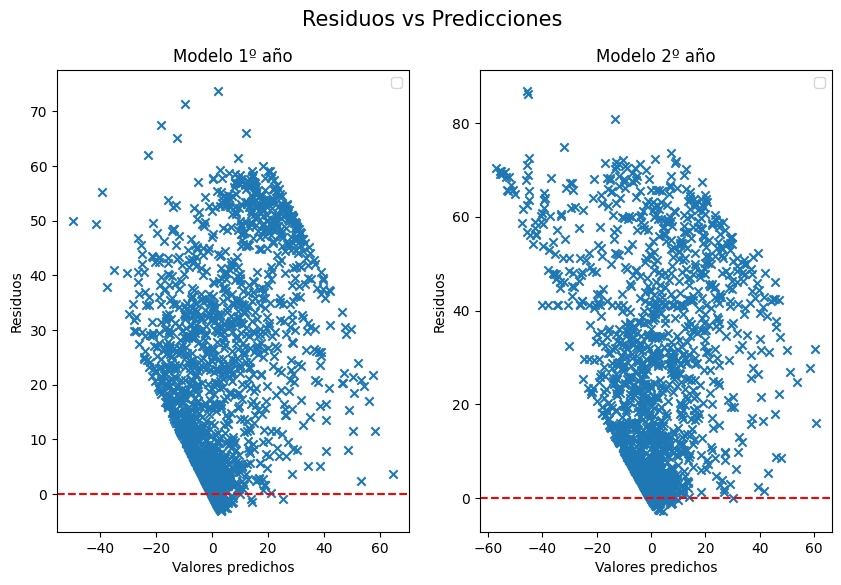

Config [168, 30, 30, 150, 0.2]
                  RMSE       MAE        R2
Iteración 1  12.196047  8.256137  0.775274
Iteración 2  13.453655  7.970143  0.705065
Stacked LSTM: 12.825 RMSE (+/- 0.629)
Stacked LSTM: 8.113 MAE (+/- 0.143)
Stacked LSTM: 0.740 R2 (+/- 0.035)


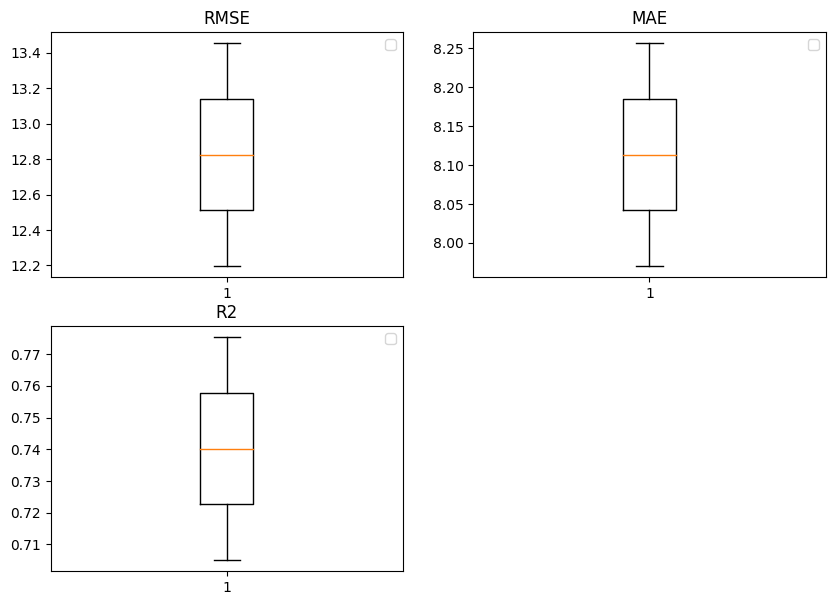

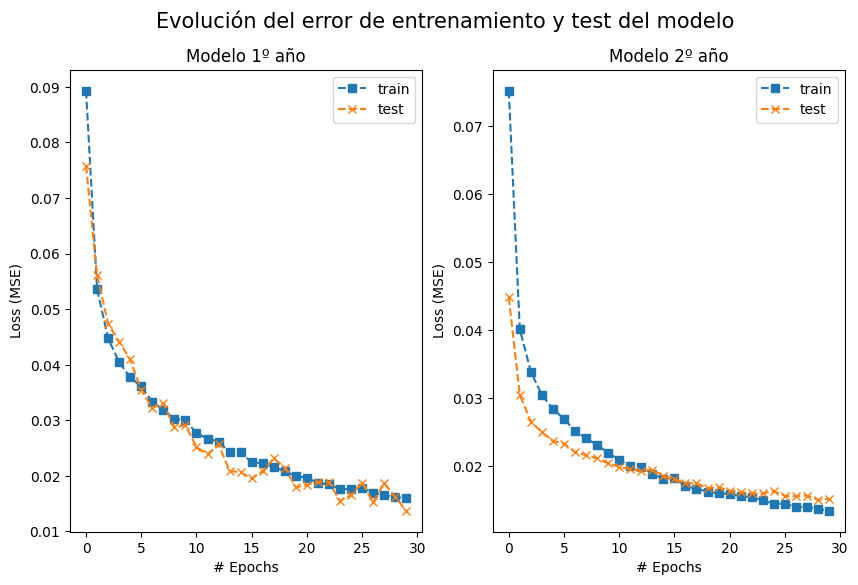

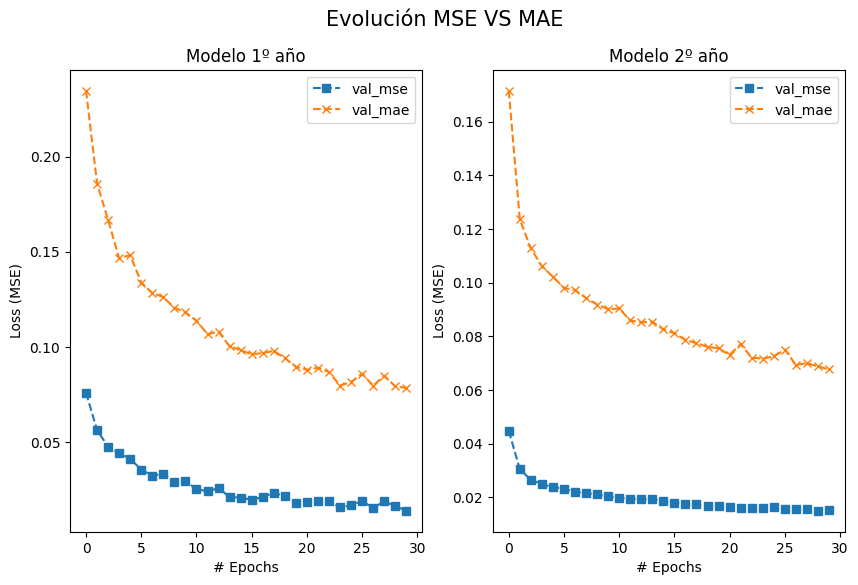

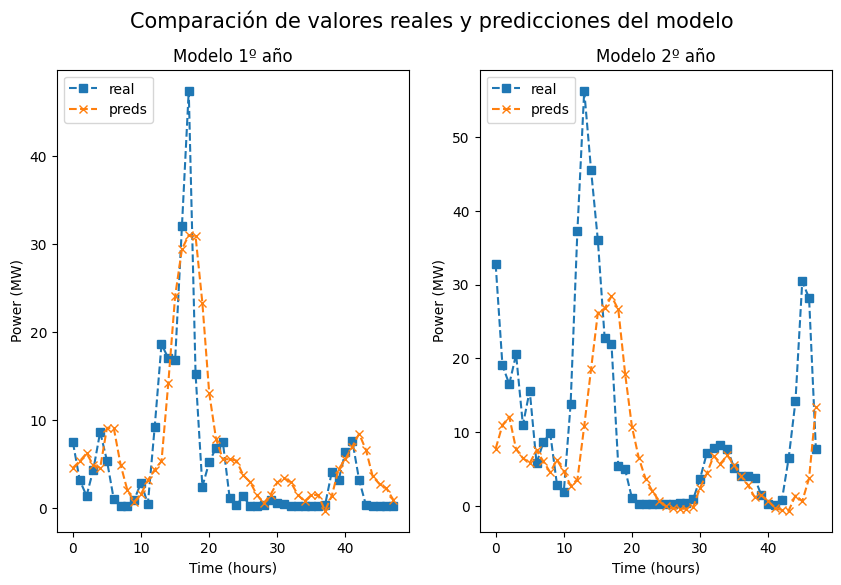

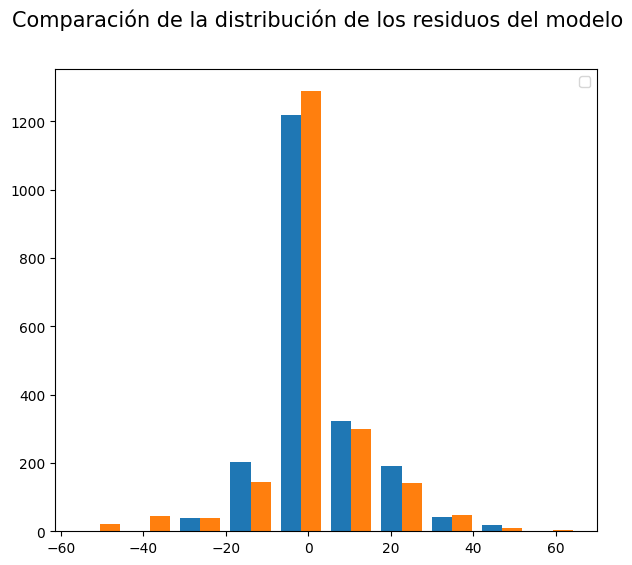

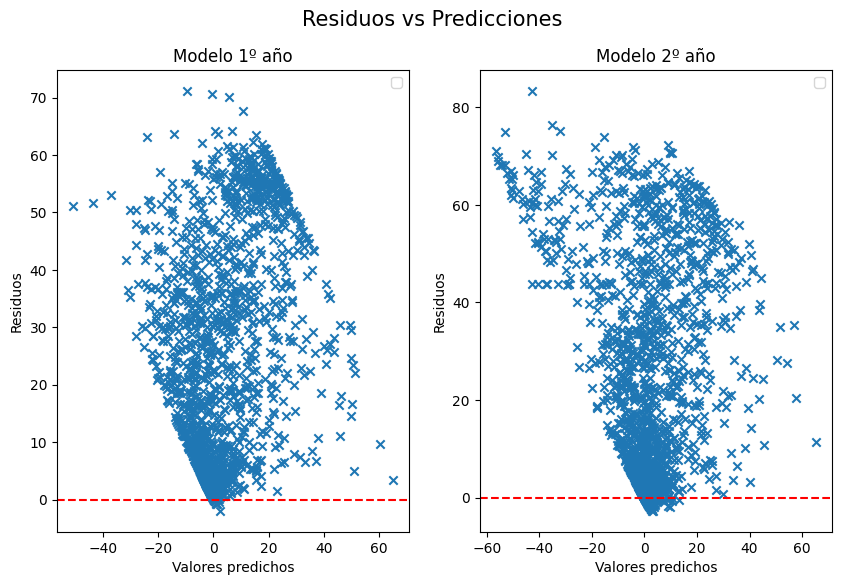

In [ ]:
scores = {config_1: (results_1, results_2) for (config_1, results_1), (config_2, results_2) in zip(scores_1, scores_2) if config_1 == config_2}
summarize_scores('Stacked LSTM', scores)